<a href="https://colab.research.google.com/github/ZacharyZekaiXu/ZekaiXu_CrossmodalRecognition/blob/main/PusherTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D pusher using Soft Actor-Critic

This tutorial shows you how to build a really simple robot that can move only in a plane and to train a policy network using soft actor-critic to control it to push a cube. The inputs to the policy network are the current end-effector position, the current position of the cube, and the target position of the cube, and the output is the end-effector velocity. The network learns to push the cube to the specified point.

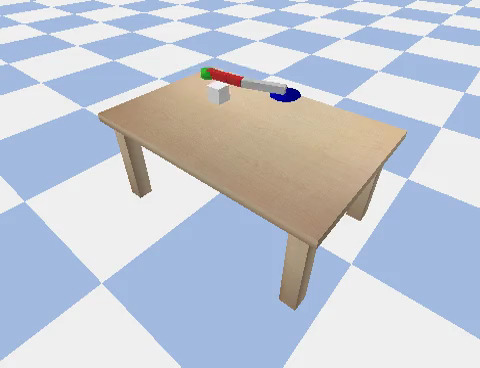

In [ ]:
%tensorflow_version 1.x
!pip install --upgrade pybullet==3.1.6 imageio-ffmpeg stable-baselines

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML
from stable_baselines.sac.policies import MlpPolicy
from stable_baselines import SAC
import gym
from gym import spaces

np.set_printoptions(precision=3)

TensorFlow 1.x selected.
     |████████████████████████████████| 89.3MB 31kB/s 
     |████████████████████████████████| 26.9MB 118kB/s 
     |████████████████████████████████| 245kB 44.5MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [ ]:
# Write custom robot URDF. See http://wiki.ros.org/urdf/Tutorials

urdf_str = '''
<?xml version="1.0"?>
<robot name="myrobot">
  <link name="base_link">
    <visual>
      <geometry>
        <cylinder length="0.01" radius="0.1"/>
      </geometry>
      <material name="blue">
        <color rgba="0 0 .8 1"/>
      </material>
    </visual>
    <collision>
      <geometry>
        <cylinder length="0.01" radius="0.1"/>
      </geometry>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <link name="arm">
    <visual>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <material name="white">
        <color rgba="0.8 0.8 .8 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </visual>
    <collision>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="base_to_arm" type="revolute">
    <parent link="base_link"/>
    <child link="arm"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

  <link name="arm2">
    <visual>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <material name="red">
        <color rgba="0.8 0.2 .2 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </visual>
    <collision>
      <geometry>
        <box size="0.05 0.3 0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0.15 0.03"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="arm_to_arm2" type="revolute">
    <parent link="arm"/>
    <child link="arm2"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0.3 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

  <link name="end_effector">
    <visual>
      <geometry>
        <cylinder length="0.05" radius="0.05"/>
      </geometry>
      <material name="greeb">
        <color rgba="0.2 0.8 .2 1"/>
      </material>
      <origin rpy="0 0 0" xyz="0 0 0.025"/>
    </visual>
    <collision>
      <geometry>
        <cylinder length="0.05" radius="0.05"/>
      </geometry>
      <origin rpy="0 0 0" xyz="0 0 0.025"/>
    </collision>
    <inertial>
      <mass value="10"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <joint name="arm2_to_end_effector" type="revolute">
    <parent link="arm2"/>
    <child link="end_effector"/>
    <axis xyz="0 0 1"/>
    <origin rpy="0 0 0" xyz="0 0.3 0"/>
    <limit effort="1000.0" lower="-3.14" upper="3.14" velocity="0.5"/>
  </joint>

</robot>
'''

with open('custom_robot.urdf', 'w') as f:
    f.write(urdf_str)

In [ ]:
# init pybullet
p.connect(p.DIRECT) # or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

# setup environment with robot
plane_id = p.loadURDF("plane.urdf")
robot_id = p.loadURDF("custom_robot.urdf", basePosition=[1.400000, -0.200000, 0.650000], useFixedBase=True)
table_id = p.loadURDF("table/table.urdf", basePosition=[1.0, -0.2, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
cube_id = p.loadURDF("cube.urdf", basePosition=[1.1, -0.2, 0.675], globalScaling=0.1)

num_joints = p.getNumJoints(robot_id)
print('Num of joints in robot:', num_joints)

# camera parameters
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360

cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [0, 0, 1], 2, 0.01, 100, 60

class PusherEnv(gym.Env):
    """Custom environment to train an agent to push an object"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(PusherEnv, self).__init__()

        # Observation is the current end effector position, cube position, and target cube position
        self.observation_space = spaces.Box(low=-3, high=3, shape=(3*3,), dtype=np.float32)

        # action is the vector of (x, y) end-effector velocities
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)
    
    def _get_end_effector_pos(self):
        end_effector_pos = p.getLinkState(bodyUniqueId=robot_id, linkIndex=2)[0]
        return np.array(end_effector_pos)
    
    def _get_cube_pos(self):
        cube_pos = p.getBasePositionAndOrientation(cube_id)[0]
        return np.array(cube_pos)
    
    def _get_obs(self):
        current_end_effector_pos = self._get_end_effector_pos()
        current_cube_pos = self._get_cube_pos()
        target_cube_pos = np.array(self.target_pos) # target position of cube
        return np.concatenate([current_end_effector_pos, current_cube_pos, target_cube_pos])

    def reset(self):
        self.t = 0
        self.start_pos = [1.1, -0.2 + np.random.uniform(-0.35, 0.35), 0.7] # goal is to push this target
        self.target_pos = [self.start_pos[0], self.start_pos[1]-1.0, self.start_pos[2]] # target position to push cube to

        for j in range(num_joints):
            p.resetJointState(bodyUniqueId=robot_id, jointIndex=j, targetValue=0, targetVelocity=0)
            p.setJointMotorControl2(bodyIndex=robot_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=0)

        p.resetBasePositionAndOrientation(cube_id, self.start_pos, [0.0, 0.0, 0.0, 1.0])
        
        for _ in range(5):
            p.stepSimulation() # step a couple of times to make there is no weirdness after resetting
        
        obs = self._get_obs()
        return obs

    def step(self, action):
        # Execute one time step within the environment

        end_effector_pos = self._get_end_effector_pos()

        next_end_effector_pos = [end_effector_pos[0]+action[0], end_effector_pos[1]+action[1], end_effector_pos[2]]
        next_end_effector_orn = p.getQuaternionFromEuler([math.pi, 0, 0])
        joint_poses = p.calculateInverseKinematics(robot_id, 2, next_end_effector_pos, next_end_effector_orn)

        for j in range(num_joints):
            p.setJointMotorControl2(bodyIndex=robot_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=joint_poses[j])
        
        for _ in range(8):
            p.stepSimulation() # step by 1.0/240 seconds
            self.t += 1

        obs = self._get_obs()
        
        current_cube_pos = self._get_cube_pos()
        #print(end_effector_pos, action, current_cube_pos, self.target_pos)

        reward = -sum(abs(pi-ti) for pi, ti in zip(current_cube_pos[:2], self.target_pos[:2]))
        reward += -sum(abs(pi-ti) for pi, ti in zip(current_cube_pos[:2], end_effector_pos[:2]))

        done = (self.t >= 4800)

        return obs, reward, done, {}
    
    def render(self):
        # render image
        #print(p.getLinkState(bodyUniqueId=robot_id, linkIndex=2)[0])
        #print(self._get_cube_pos(), self.target_pos)
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(cam_fov, cam_width*1./cam_height, cam_near_plane, cam_far_plane)
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        image = np.ascontiguousarray(image)
        return image

env = PusherEnv()

model = SAC(MlpPolicy, env, verbose=0)
model.learn(total_timesteps=15000, log_interval=10000)
model.save("sac_pusher_env")

del model # remove to demonstrate saving and loading

model = SAC.load("sac_pusher_env")

vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None) # seed the video writer with a blank frame

# Enjoy trained agent
for i in range(1):
    obs = env.reset()
    for j in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        image = env.render()
        vid.send(image)
        if done:
            break

vid.close()
p.disconnect()

Num of joints in robot: 3


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (480, 360) to (480, 368) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
# Play recorded video

mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)